This project is designed to create a CNN classifier using images pulled from reddit.com/r/Art

Image classification is a widely used process and a significant ammount of research and applied technologies have indicated that convolutional neural networks are one of the most optimal algorithms for image recognition. Convolutional neural networks have proven to be highly capable and extremely accurate at recognizing objects within images as well as classifying scans of tissue as malignant or benign. This project will be something simmilar to the latter of the two in that the objects in the image are irrelevant, instead I'm trying to get my model to pick up on the small details in the image that would indicate the difference between a real brushstroke and a digital brushstroke.



First I'll need to import all of this project's dependencies as well as creating paths to the relevant source code and data directories within the repository

In [1]:
# creating paths to src and data folders in the repo
import sys
import pathlib
src_path = pathlib.Path().absolute().parent.parent / "src"
data_path = pathlib.Path().absolute().parent.parent / "data"
sys.path.append(str(src_path))

# source code functions for this project
import data_setup as ds
import modeling_functions as mf

# basic imports for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# import modeling packages
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# modeling metrics
from sklearn.metrics import classification_report, confusion_matrix

Now I'll need to create an instance of the pushshift psaw api. This api will allow me to search through all of reddit's content to retrieve the submissions required to build my dataset.

In [2]:
reddit = ds.get_api_instance(src_path)

Next I'll use this api to pull data from as many posts as I'd like. for this project I used a dataset of 6400 images, 3200 that were made using digital means, and 3200 made using other means. Only about one third of posts made to r/Art are created using digital means, so my function fetch_balanced_submissions ensures that an equal number of posts is collected from each category to produce a balanced dataset.

In [3]:
table_of_contents = [ds.make_post_dict(post) for post in ds.fetch_balanced_submissions(6400, reddit, binary=True)]

(3200, 6400)
polling pushshift for 6400 more posts before 1606347164
polling pushshift for 6366 more posts before 1606337467
polling pushshift for 6330 more posts before 1606328894
polling pushshift for 6288 more posts before 1606320908
polling pushshift for 6252 more posts before 1606311958
polling pushshift for 6217 more posts before 1606300454
polling pushshift for 6191 more posts before 1606287315
polling pushshift for 6156 more posts before 1606274937
polling pushshift for 6127 more posts before 1606263956
polling pushshift for 6092 more posts before 1606254179
polling pushshift for 6055 more posts before 1606244735
polling pushshift for 6017 more posts before 1606236335
polling pushshift for 5962 more posts before 1606227773
polling pushshift for 5923 more posts before 1606218417
polling pushshift for 5884 more posts before 1606204271
polling pushshift for 5843 more posts before 1606189691
polling pushshift for 5813 more posts before 1606177676
polling pushshift for 5766 more pos

polling pushshift for 1966 more posts before 1604851241
polling pushshift for 1946 more posts before 1604841865
polling pushshift for 1926 more posts before 1604828494
polling pushshift for 1904 more posts before 1604814598
polling pushshift for 1884 more posts before 1604801501
polling pushshift for 1864 more posts before 1604790378
polling pushshift for 1845 more posts before 1604782889
polling pushshift for 1823 more posts before 1604775286
polling pushshift for 1793 more posts before 1604763324
polling pushshift for 1768 more posts before 1604754202
polling pushshift for 1744 more posts before 1604740870
polling pushshift for 1714 more posts before 1604723372
polling pushshift for 1688 more posts before 1604710918
polling pushshift for 1661 more posts before 1604702308
polling pushshift for 1635 more posts before 1604695143
polling pushshift for 1600 more posts before 1604689500
polling pushshift for 1575 more posts before 1604533102
polling pushshift for 1554 more posts before 160

polling pushshift for 765 more posts before 1603070175
polling pushshift for 761 more posts before 1603058445
polling pushshift for 758 more posts before 1603050580
polling pushshift for 751 more posts before 1603042717
polling pushshift for 745 more posts before 1603034877
polling pushshift for 742 more posts before 1603026358
polling pushshift for 736 more posts before 1603011942
polling pushshift for 735 more posts before 1602996130
polling pushshift for 734 more posts before 1602983058
polling pushshift for 729 more posts before 1602975428
polling pushshift for 727 more posts before 1602966627
polling pushshift for 725 more posts before 1602957521
polling pushshift for 720 more posts before 1602948903
polling pushshift for 716 more posts before 1602939118
polling pushshift for 711 more posts before 1602928692
polling pushshift for 710 more posts before 1602912340
polling pushshift for 708 more posts before 1602901223
polling pushshift for 705 more posts before 1602890267
polling pu

polling pushshift for 602 more posts before 1601563679
polling pushshift for 600 more posts before 1601555870
polling pushshift for 600 more posts before 1601544677
polling pushshift for 600 more posts before 1601529753
polling pushshift for 600 more posts before 1601515298
polling pushshift for 600 more posts before 1601504831
polling pushshift for 600 more posts before 1601496134
polling pushshift for 598 more posts before 1601488637
polling pushshift for 598 more posts before 1601480358
polling pushshift for 598 more posts before 1601472671
polling pushshift for 597 more posts before 1601460797
polling pushshift for 596 more posts before 1601446674
polling pushshift for 595 more posts before 1601431833
polling pushshift for 595 more posts before 1601418566
polling pushshift for 595 more posts before 1601410675
polling pushshift for 594 more posts before 1601402936
polling pushshift for 594 more posts before 1601397122
polling pushshift for 592 more posts before 1601390392
polling pu

polling pushshift for 539 more posts before 1599958443
polling pushshift for 538 more posts before 1599949238
polling pushshift for 535 more posts before 1599940815
polling pushshift for 534 more posts before 1599931806
polling pushshift for 533 more posts before 1599924200
polling pushshift for 532 more posts before 1599915310
polling pushshift for 532 more posts before 1599901727
polling pushshift for 531 more posts before 1599884305
polling pushshift for 531 more posts before 1599871444
polling pushshift for 531 more posts before 1599861559
polling pushshift for 531 more posts before 1599854249
polling pushshift for 531 more posts before 1599846410
polling pushshift for 530 more posts before 1599838649
polling pushshift for 528 more posts before 1599829168
polling pushshift for 528 more posts before 1599817313
polling pushshift for 528 more posts before 1599803359
polling pushshift for 528 more posts before 1599790013
polling pushshift for 528 more posts before 1599779188
polling pu

polling pushshift for 474 more posts before 1598466762
polling pushshift for 474 more posts before 1598459047
polling pushshift for 472 more posts before 1598450580
polling pushshift for 471 more posts before 1598439230
polling pushshift for 471 more posts before 1598424521
polling pushshift for 471 more posts before 1598414956
polling pushshift for 471 more posts before 1598404444
polling pushshift for 471 more posts before 1598395491
polling pushshift for 471 more posts before 1598388023
polling pushshift for 470 more posts before 1598380809
polling pushshift for 470 more posts before 1598372798
polling pushshift for 469 more posts before 1598365033
polling pushshift for 468 more posts before 1598357173
polling pushshift for 466 more posts before 1598345508
polling pushshift for 466 more posts before 1598333064
polling pushshift for 466 more posts before 1598323553
polling pushshift for 466 more posts before 1598313581
polling pushshift for 465 more posts before 1598305498
polling pu

polling pushshift for 411 more posts before 1597019950
polling pushshift for 410 more posts before 1597012133
polling pushshift for 409 more posts before 1597003896
polling pushshift for 409 more posts before 1596994710
polling pushshift for 409 more posts before 1596987430
polling pushshift for 409 more posts before 1596978411
polling pushshift for 409 more posts before 1596967320
polling pushshift for 409 more posts before 1596952940
polling pushshift for 409 more posts before 1596940339
polling pushshift for 409 more posts before 1596930386
polling pushshift for 409 more posts before 1596921729
polling pushshift for 409 more posts before 1596913508
polling pushshift for 409 more posts before 1596905748
polling pushshift for 406 more posts before 1596899009
polling pushshift for 406 more posts before 1596888618
polling pushshift for 406 more posts before 1596874520
polling pushshift for 406 more posts before 1596864204
polling pushshift for 406 more posts before 1596852959
polling pu

polling pushshift for 362 more posts before 1595857620
polling pushshift for 360 more posts before 1595849066
polling pushshift for 359 more posts before 1595840730
polling pushshift for 359 more posts before 1595829061
polling pushshift for 359 more posts before 1595821250
polling pushshift for 359 more posts before 1595815518
polling pushshift for 359 more posts before 1595806280
polling pushshift for 359 more posts before 1595799248
polling pushshift for 359 more posts before 1595792451
polling pushshift for 358 more posts before 1595785836
polling pushshift for 358 more posts before 1595779332
polling pushshift for 358 more posts before 1595771967
polling pushshift for 358 more posts before 1595765387
polling pushshift for 357 more posts before 1595753817
polling pushshift for 357 more posts before 1595741408
polling pushshift for 357 more posts before 1595732648
polling pushshift for 357 more posts before 1595723253
polling pushshift for 357 more posts before 1595716088
polling pu

polling pushshift for 301 more posts before 1594655295
polling pushshift for 301 more posts before 1594649052
polling pushshift for 301 more posts before 1594641116
polling pushshift for 300 more posts before 1594629461
polling pushshift for 300 more posts before 1594617357
polling pushshift for 300 more posts before 1594607015
polling pushshift for 300 more posts before 1594598600
polling pushshift for 300 more posts before 1594592971
polling pushshift for 300 more posts before 1594586245
polling pushshift for 299 more posts before 1594579109
polling pushshift for 298 more posts before 1594571500
polling pushshift for 297 more posts before 1594565879
polling pushshift for 297 more posts before 1594554450
polling pushshift for 294 more posts before 1594542208
polling pushshift for 292 more posts before 1594531353
polling pushshift for 290 more posts before 1594521578
polling pushshift for 290 more posts before 1594512123
polling pushshift for 290 more posts before 1594505458
polling pu

polling pushshift for 244 more posts before 1593383010
polling pushshift for 244 more posts before 1593375124
polling pushshift for 244 more posts before 1593369669
polling pushshift for 244 more posts before 1593361515
polling pushshift for 243 more posts before 1593355568
polling pushshift for 243 more posts before 1593349013
polling pushshift for 243 more posts before 1593337693
polling pushshift for 243 more posts before 1593324835
polling pushshift for 243 more posts before 1593314993
polling pushshift for 243 more posts before 1593307118
polling pushshift for 243 more posts before 1593298896
polling pushshift for 243 more posts before 1593291701
polling pushshift for 243 more posts before 1593284160
polling pushshift for 242 more posts before 1593277316
polling pushshift for 242 more posts before 1593270719
polling pushshift for 242 more posts before 1593261986
polling pushshift for 241 more posts before 1593250364
polling pushshift for 241 more posts before 1593239375
polling pu

polling pushshift for 184 more posts before 1592069670
polling pushshift for 184 more posts before 1592064550
polling pushshift for 184 more posts before 1592058986
polling pushshift for 184 more posts before 1592050871
polling pushshift for 184 more posts before 1592043138
polling pushshift for 184 more posts before 1592030386
polling pushshift for 184 more posts before 1592019544
polling pushshift for 184 more posts before 1592009410
polling pushshift for 184 more posts before 1592001230
polling pushshift for 183 more posts before 1591995057
polling pushshift for 182 more posts before 1591987154
polling pushshift for 181 more posts before 1591980862
polling pushshift for 180 more posts before 1591973358
polling pushshift for 180 more posts before 1591964540
polling pushshift for 180 more posts before 1591954575
polling pushshift for 180 more posts before 1591943295
polling pushshift for 180 more posts before 1591934552
polling pushshift for 180 more posts before 1591925015
polling pu

polling pushshift for 139 more posts before 1590873962
polling pushshift for 139 more posts before 1590865349
polling pushshift for 138 more posts before 1590859924
polling pushshift for 138 more posts before 1590852671
polling pushshift for 138 more posts before 1590843490
polling pushshift for 138 more posts before 1590830677
polling pushshift for 137 more posts before 1590819005
polling pushshift for 137 more posts before 1590810304
polling pushshift for 137 more posts before 1590802945
polling pushshift for 136 more posts before 1590795071
polling pushshift for 135 more posts before 1590788737
polling pushshift for 135 more posts before 1590781234
polling pushshift for 135 more posts before 1590774099
polling pushshift for 135 more posts before 1590768526
polling pushshift for 135 more posts before 1590760910
polling pushshift for 135 more posts before 1590748800
polling pushshift for 135 more posts before 1590735703
polling pushshift for 134 more posts before 1590725576
polling pu

polling pushshift for 94 more posts before 1589646393
polling pushshift for 94 more posts before 1589639454
polling pushshift for 94 more posts before 1589629515
polling pushshift for 94 more posts before 1589613098
polling pushshift for 94 more posts before 1589603375
polling pushshift for 93 more posts before 1589595209
polling pushshift for 93 more posts before 1589587501
polling pushshift for 92 more posts before 1589579764
polling pushshift for 91 more posts before 1589573754
polling pushshift for 90 more posts before 1589568403
polling pushshift for 90 more posts before 1589563606
polling pushshift for 89 more posts before 1589558309
polling pushshift for 89 more posts before 1589552947
polling pushshift for 89 more posts before 1589544931
polling pushshift for 89 more posts before 1589535252
polling pushshift for 89 more posts before 1589524591
polling pushshift for 88 more posts before 1589516142
polling pushshift for 87 more posts before 1589506881
polling pushshift for 86 mor

polling pushshift for 43 more posts before 1588427786
polling pushshift for 43 more posts before 1588418668
polling pushshift for 43 more posts before 1588410877
polling pushshift for 42 more posts before 1588401025
polling pushshift for 41 more posts before 1588391859
polling pushshift for 41 more posts before 1588386443
polling pushshift for 41 more posts before 1588378058
polling pushshift for 41 more posts before 1588370946
polling pushshift for 40 more posts before 1588365741
polling pushshift for 39 more posts before 1588359024
polling pushshift for 39 more posts before 1588353858
polling pushshift for 38 more posts before 1588347862
polling pushshift for 38 more posts before 1588342018
polling pushshift for 38 more posts before 1588334344
polling pushshift for 37 more posts before 1588322307
polling pushshift for 36 more posts before 1588309406
polling pushshift for 36 more posts before 1588301931
polling pushshift for 36 more posts before 1588295077
polling pushshift for 36 mor

I'm also writting the most critical meta-data to a json file so that it won't be lost when restarting the kernel

In [4]:
writeable_toc = [ds.make_post_dict_no_obj(post['post']) for post in table_of_contents]
toc_path = data_path / 'meta_data_final.json'
with open(toc_path, 'x') as f:
    f.write(json.dumps(writeable_toc))

In [5]:
# run this to load the json file into memory

# toc_path = data_path / 'meta_data_final.json'
# json_string = open(str(toc_path)).read()
# loaded_toc = json.loads(json_string)
# table_of_contents = loaded_toc

I'm taking a look at the distribution of medium types. Although it's only a binary classifiation there are still a total of 5 different medium classes (digital and non-digital which contains 4 classes: ink, non-ink-drawing, paint, sculpture)

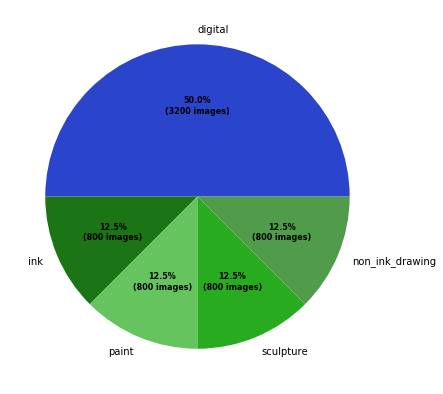

In [6]:
toc_df = pd.DataFrame(table_of_contents)

fig_path = pathlib.Path().absolute().parent.parent / "reports/figures"

colors = ("#2A45CC", "#1C7515","#65C45E",
          "#28AB1F", "#509C4B", "#2DC223") 

def get_percentages(pct, allvalues): 
    absolute = int(pct / 100.*sum(allvalues)) 
    return "{:.1f}%\n({:d} images)".format(pct, absolute) 
  
# Creating plot 
fig, ax = plt.subplots(figsize =(10, 7)) 
wedges, texts, autotexts = ax.pie(toc_df.medium.value_counts().values,  
                                  autopct = lambda pct: get_percentages(pct, list(toc_df.medium.value_counts().values)), 
                                  labels = toc_df.medium.value_counts().index,
                                  colors = colors,
                                  textprops = dict(color='black'),
                                  startangle = 0)
  
plt.setp(autotexts, size = 8, weight ="bold")
  
pie_path = fig_path / 'pie_distribution_final_black.png'
plt.savefig(pie_path, transparent=True)
plt.show()

For this project I used the flow-from-directory process to sequentially load batches of images to train on. This requires a specificlly formatted directory structure. establish_binary_directory creates the file structure required for flow-from-directory process within the specified file path.

Once the file structure is established, I can begin downloading the images for each post and storing them in their propper folders using download_and_store_binary. I used 3000 images per category for training, 100 per category for testing, and 100 per category for validation.

In [7]:
toc_df = pd.DataFrame(table_of_contents)
toc_df.medium.value_counts()

digital            3200
ink                 800
paint               800
sculpture           800
non_ink_drawing     800
Name: medium, dtype: int64

In [9]:
# create a directory structure to store sorted images with a train/test/validation split
#ds.establish_binary_directory(data_path)

# download, sort, split, and store images from each post into the new file structure
# the filename for each image will be set using the format 'postid.(jpg|png)'
binary_data_path = data_path / 'binary_tts'
ds.download_and_store_binary(table_of_contents, binary_data_path, [3000, 100, 100])

downloading k13j2r with 3199 remaining in digital
k13j2r.jpg already exists
downloading k13hnr with 3198 remaining in digital
k13hnr.png already exists
downloading k139o0 with 3197 remaining in digital
k139o0.jpg already exists
downloading k12wo7 with 3196 remaining in digital
k12wo7.png already exists
downloading k12vhd with 3195 remaining in digital
k12vhd.png already exists
downloading k12qdg with 3194 remaining in digital
k12qdg.jpg already exists
downloading k12f76 with 3193 remaining in digital
k12f76.jpg already exists
downloading k12dxe with 3192 remaining in digital
k12dxe.jpg already exists
downloading k12dkm with 3191 remaining in digital
k12dkm.jpg already exists
downloading k126p9 with 3190 remaining in digital
k126p9.jpg already exists
downloading k124yv with 3189 remaining in digital
k124yv.jpg already exists
downloading k124hl with 3188 remaining in digital
k124hl.jpg already exists
downloading k11zbf with 3187 remaining in digital
k11zbf.jpg already exists
downloading 

downloading jxug3j with 2390 remaining in digital
downloading jxub2i with 2389 remaining in digital
downloading jxu7f1 with 2388 remaining in digital
downloading jxu2j5 with 2387 remaining in digital
downloading jxu0nk with 2386 remaining in digital
downloading jxtx6i with 2385 remaining in digital
downloading jxtfs6 with 2384 remaining in digital
downloading jxte3b with 2383 remaining in digital
downloading jxte1u with 2382 remaining in digital
downloading jxtdvu with 2381 remaining in digital
downloading jxtbj1 with 2380 remaining in digital
downloading jxt53z with 2379 remaining in digital
downloading jxt4l0 with 2378 remaining in digital
downloading jxswrk with 2377 remaining in digital
downloading jxsugf with 2376 remaining in digital
downloading jxsrsu with 2375 remaining in digital
downloading jxsq7f with 2374 remaining in digital
downloading jxspgg with 2373 remaining in digital
downloading jxsjca with 2372 remaining in digital
downloading jxsek4 with 2371 remaining in digital


downloading jx3u52 with 2226 remaining in digital
downloading jx3im9 with 2225 remaining in digital
downloading jx3i2d with 2224 remaining in digital
downloading jx3hxb with 2223 remaining in digital
downloading jx3ekp with 2222 remaining in digital
downloading jx3efn with 2221 remaining in digital
downloading jx36t8 with 2220 remaining in digital
downloading jx36n0 with 2219 remaining in digital
downloading jx32i1 with 2218 remaining in digital
downloading jx2xh9 with 2217 remaining in digital
downloading jx2kig with 2216 remaining in digital
downloading jx2dkq with 2215 remaining in digital
downloading jx20o0 with 2214 remaining in digital
downloading jx1xv1 with 2213 remaining in digital
downloading jx1xnl with 2212 remaining in digital
downloading jx1lho with 2211 remaining in digital
downloading jx1emo with 2210 remaining in digital
downloading jx1ccs with 2209 remaining in digital
downloading jx10fv with 2208 remaining in digital
downloading jx0ouu with 2207 remaining in digital


downloading jwd47s with 2062 remaining in digital
downloading jwd2ds with 2061 remaining in digital
downloading jwcygr with 2060 remaining in digital
downloading jwcwuf with 2059 remaining in digital
downloading jwcach with 2058 remaining in digital
downloading jwc5zs with 2057 remaining in digital
downloading jwc1zg with 2056 remaining in digital
downloading jwbo04 with 2055 remaining in digital
downloading jwbngo with 2054 remaining in digital
downloading jwbm03 with 2053 remaining in digital
downloading jwbehr with 2052 remaining in digital
downloading jwau8w with 2051 remaining in digital
downloading jwarjd with 2050 remaining in digital
downloading jwanxf with 2049 remaining in digital
downloading jwalk0 with 2048 remaining in digital
downloading jwaihh with 2047 remaining in digital
downloading jwa73j with 2046 remaining in digital
downloading jwa5a5 with 2045 remaining in digital
downloading jw9th9 with 2044 remaining in digital
downloading jw9qk2 with 2043 remaining in digital


downloading jvq7w2 with 1898 remaining in digital
downloading jvq5z4 with 1897 remaining in digital
downloading jvq5h2 with 1896 remaining in digital
downloading jvpy8x with 1895 remaining in digital
downloading jvpozf with 1894 remaining in digital
downloading jvp2wn with 1893 remaining in digital
downloading jvp0sd with 1892 remaining in digital
downloading jvonb9 with 1891 remaining in digital
downloading jvon1h with 1890 remaining in digital
downloading jvok6u with 1889 remaining in digital
downloading jvn85s with 1888 remaining in digital
downloading jvn716 with 1887 remaining in digital
downloading jvn6ju with 1886 remaining in digital
downloading jvn61s with 1885 remaining in digital
downloading jvn4rb with 1884 remaining in digital
downloading jvmr3x with 1883 remaining in digital
downloading jvmo6x with 1882 remaining in digital
downloading jvm6n3 with 1881 remaining in digital
downloading jvm34f with 1880 remaining in digital
downloading jvlzuu with 1879 remaining in digital


downloading jv39ns with 1733 remaining in digital
downloading jv39ms with 1732 remaining in digital
downloading jv38k6 with 1731 remaining in digital
downloading jv34es with 1730 remaining in digital
downloading jv2xy1 with 1729 remaining in digital
downloading jv2sbz with 1728 remaining in digital
downloading jv2rev with 1727 remaining in digital
downloading jv2oyh with 1726 remaining in digital
downloading jv2lj9 with 1725 remaining in digital
downloading jv2dnw with 1724 remaining in digital
downloading jv2b83 with 1723 remaining in digital
downloading jv22sq with 1722 remaining in digital
downloading jv1wu7 with 1721 remaining in digital
downloading jv1vso with 1720 remaining in digital
downloading jv1tew with 1719 remaining in digital
downloading jv1q9u with 1718 remaining in digital
downloading jv1lxf with 1717 remaining in digital
downloading jv1kd0 with 1716 remaining in digital
downloading jv1d8h with 1715 remaining in digital
downloading jv1cw6 with 1714 remaining in digital


downloading jugjfl with 1569 remaining in digital
downloading jugglo with 1568 remaining in digital
downloading jugchf with 1567 remaining in digital
downloading jug9sp with 1566 remaining in digital
downloading jug3nn with 1565 remaining in digital
downloading jug1ax with 1564 remaining in digital
downloading jug01w with 1563 remaining in digital
downloading jufsza with 1562 remaining in digital
downloading jufprm with 1561 remaining in digital
downloading juflp3 with 1560 remaining in digital
downloading jufjss with 1559 remaining in digital
downloading jufdq6 with 1558 remaining in digital
downloading juf1pa with 1557 remaining in digital
downloading juemv8 with 1556 remaining in digital
downloading jue605 with 1555 remaining in digital
downloading jue5nk with 1554 remaining in digital
downloading jue2e2 with 1553 remaining in digital
downloading judm52 with 1552 remaining in digital
downloading judire with 1551 remaining in digital
downloading judir4 with 1550 remaining in digital


downloading jtsql3 with 1404 remaining in digital
downloading jtsmm5 with 1403 remaining in digital
downloading jtslt9 with 1402 remaining in digital
downloading jtsdow with 1401 remaining in digital
downloading jtsais with 1400 remaining in digital
downloading jts88m with 1399 remaining in digital
downloading jts5xi with 1398 remaining in digital
downloading jts519 with 1397 remaining in digital
downloading jtryjk with 1396 remaining in digital
downloading jtrv7o with 1395 remaining in digital
downloading jtrtn5 with 1394 remaining in digital
downloading jtrqon with 1393 remaining in digital
downloading jtrml2 with 1392 remaining in digital
downloading jtrjf1 with 1391 remaining in digital
downloading jtrim3 with 1390 remaining in digital
downloading jtrgvn with 1389 remaining in digital
downloading jtr797 with 1388 remaining in digital
downloading jtqxs4 with 1387 remaining in digital
downloading jtqvv2 with 1386 remaining in digital
downloading jtqtvw with 1385 remaining in digital


downloading jt3jw6 with 1239 remaining in digital
downloading jt3h8t with 1238 remaining in digital
downloading jt3gt1 with 1237 remaining in digital
downloading jt3734 with 1236 remaining in digital
downloading jt34mk with 1235 remaining in digital
downloading jt2v6n with 1234 remaining in digital
downloading jt2r16 with 1233 remaining in digital
downloading jt2iuo with 1232 remaining in digital
downloading jt2c6t with 1231 remaining in digital
downloading jt2aj3 with 1230 remaining in digital
downloading jt2a2r with 1229 remaining in digital
downloading jt29qi with 1228 remaining in digital
downloading jt28x8 with 1227 remaining in digital
downloading jt25oo with 1226 remaining in digital
downloading jt24u9 with 1225 remaining in digital
downloading jt1zvp with 1224 remaining in digital
downloading jt1vom with 1223 remaining in digital
downloading jt1vmi with 1222 remaining in digital
downloading jt1v63 with 1221 remaining in digital
downloading jt1lwr with 1220 remaining in digital


downloading jsh5r3 with 1074 remaining in digital
downloading jsh31o with 1073 remaining in digital
downloading jsh0wt with 1072 remaining in digital
downloading jsg7wn with 1071 remaining in digital
downloading jsg5i0 with 1070 remaining in digital
downloading jsg07r with 1069 remaining in digital
downloading jsfyey with 1068 remaining in digital
downloading jsfota with 1067 remaining in digital
downloading jsfjhg with 1066 remaining in digital
downloading jsfj10 with 1065 remaining in digital
downloading jsez6j with 1064 remaining in digital
downloading jsez2m with 1063 remaining in digital
downloading jseuot with 1062 remaining in digital
downloading jsenxb with 1061 remaining in digital
downloading jseimr with 1060 remaining in digital
downloading jsecxs with 1059 remaining in digital
downloading jse0z5 with 1058 remaining in digital
downloading jsds7x with 1057 remaining in digital
downloading jsdnzy with 1056 remaining in digital
downloading jsd69b with 1055 remaining in digital


downloading jrpcnq with 908 remaining in digital
downloading jrp8bk with 907 remaining in digital
downloading jrozf9 with 906 remaining in digital
downloading jroxkx with 905 remaining in digital
downloading jrow46 with 904 remaining in digital
downloading jrovrx with 903 remaining in digital
downloading jroubn with 902 remaining in digital
downloading jros2u with 901 remaining in digital
downloading jropc0 with 900 remaining in digital
downloading jroomu with 899 remaining in digital
downloading jronqc with 898 remaining in digital
downloading jroig9 with 897 remaining in digital
downloading jroent with 896 remaining in digital
downloading jroakh with 895 remaining in digital
downloading jro7xe with 894 remaining in digital
downloading jrnzn5 with 893 remaining in digital
downloading jrnw0o with 892 remaining in digital
downloading jrnvm8 with 891 remaining in digital
downloading jrnt3r with 890 remaining in digital
downloading jrnpih with 889 remaining in digital
downloading jrncz5 w

downloading jr2593 with 740 remaining in digital
downloading jr1xyz with 739 remaining in digital
downloading jr1u71 with 738 remaining in digital
downloading jr1p10 with 737 remaining in digital
downloading jr1kji with 736 remaining in digital
downloading jr1jk0 with 735 remaining in digital
downloading jr1h4c with 734 remaining in digital
downloading jr1gu4 with 733 remaining in digital
downloading jr1eu8 with 732 remaining in digital
downloading jr1119 with 731 remaining in digital
downloading jr10yi with 730 remaining in digital
downloading jr0wyp with 729 remaining in digital
downloading jr0jni with 728 remaining in digital
downloading jr0j0r with 727 remaining in digital
downloading jr0gpn with 726 remaining in digital
downloading jr0fu3 with 725 remaining in digital
downloading jr0fof with 724 remaining in digital
downloading jr04hm with 723 remaining in digital
downloading jr016y with 722 remaining in digital
downloading jr009k with 721 remaining in digital
downloading jr009j w

downloading jqfvrp with 572 remaining in digital
downloading jqftlz with 571 remaining in digital
downloading jqfk46 with 570 remaining in digital
downloading jqfh17 with 569 remaining in digital
downloading jqfe0u with 568 remaining in digital
downloading jqevt0 with 567 remaining in digital
downloading jqed43 with 566 remaining in digital
downloading jqe4ez with 565 remaining in digital
downloading jqdxvb with 564 remaining in digital
downloading jqduj6 with 563 remaining in digital
downloading jqdpe5 with 562 remaining in digital
downloading jqdog3 with 561 remaining in digital
downloading jqdjux with 560 remaining in digital
downloading jqdc1q with 559 remaining in digital
downloading jqdbwh with 558 remaining in digital
downloading jqd7rw with 557 remaining in digital
downloading jqd4g7 with 556 remaining in digital
downloading jqcyxn with 555 remaining in digital
downloading jqcven with 554 remaining in digital
downloading jqctx4 with 553 remaining in digital
downloading jqcsao w

downloading jpqfhi with 404 remaining in digital
downloading jpqbsr with 403 remaining in digital
downloading jppuv7 with 402 remaining in digital
downloading jppuaz with 401 remaining in digital
downloading jppnox with 400 remaining in digital
downloading jpphrk with 399 remaining in digital
downloading jppb9u with 398 remaining in digital
downloading jpp9hb with 397 remaining in digital
downloading jpp8or with 396 remaining in digital
downloading jpp2sc with 395 remaining in digital
downloading jpozjq with 394 remaining in digital
downloading jpoyv3 with 393 remaining in digital
downloading jpowpm with 392 remaining in digital
downloading jpowou with 391 remaining in digital
downloading jpoqyz with 390 remaining in digital
downloading jpodlt with 389 remaining in digital
downloading jpo2ej with 388 remaining in digital
downloading jpo1qx with 387 remaining in digital
downloading jpnzve with 386 remaining in digital
downloading jpnvxy with 385 remaining in digital
downloading jpnsvc w

downloading jo4770 with 236 remaining in digital
downloading jo3z97 with 235 remaining in digital
downloading jo3z82 with 234 remaining in digital
downloading jo3nr2 with 233 remaining in digital
downloading jo3non with 232 remaining in digital
downloading jo3nam with 231 remaining in digital
downloading jo3dpl with 230 remaining in digital
downloading jo398m with 229 remaining in digital
downloading jo33ic with 228 remaining in digital
downloading jo2z2t with 227 remaining in digital
downloading jo2yxl with 226 remaining in digital
downloading jo2w1r with 225 remaining in digital
downloading jo2w0p with 224 remaining in digital
downloading jo2pt5 with 223 remaining in digital
downloading jo2jqy with 222 remaining in digital
downloading jo291z with 221 remaining in digital
downloading jo27d6 with 220 remaining in digital
downloading jo1wte with 219 remaining in digital
downloading jo1ond with 218 remaining in digital
downloading jo1cg8 with 217 remaining in digital
downloading jo1444 w

downloading jngrmi with 68 remaining in digital
downloading jngmv3 with 67 remaining in digital
downloading jnghsa with 66 remaining in digital
downloading jngfye with 65 remaining in digital
downloading jnfzze with 64 remaining in digital
downloading jnfx26 with 63 remaining in digital
downloading jnfw1z with 62 remaining in digital
downloading jnfw00 with 61 remaining in digital
downloading jnfpn3 with 60 remaining in digital
downloading jnfi92 with 59 remaining in digital
downloading jnfccb with 58 remaining in digital
downloading jnermd with 57 remaining in digital
downloading jnepje with 56 remaining in digital
downloading jnenes with 55 remaining in digital
downloading jnefe6 with 54 remaining in digital
downloading jnee2y with 53 remaining in digital
downloading jne8w2 with 52 remaining in digital
downloading jndvec with 51 remaining in digital
downloading jndt85 with 50 remaining in digital
downloading jndqlm with 49 remaining in digital
downloading jndf10 with 48 remaining in 

downloading k0ms07 with 3108 remaining in non_digital
downloading k0mqia with 3107 remaining in non_digital
downloading k0mpuc with 3106 remaining in non_digital
downloading k0mcfg with 3105 remaining in non_digital
downloading k0m7b3 with 3104 remaining in non_digital
downloading k0ly0p with 3103 remaining in non_digital
downloading k0lpk9 with 3102 remaining in non_digital
downloading k0ll3v with 3101 remaining in non_digital
downloading k0ljsh with 3100 remaining in non_digital
downloading k0lgej with 3099 remaining in non_digital
downloading k0ld6a with 3098 remaining in non_digital
downloading k0ld0o with 3097 remaining in non_digital
downloading k0l5li with 3096 remaining in non_digital
downloading k0l4vb with 3095 remaining in non_digital
downloading k0k98e with 3094 remaining in non_digital
downloading k0juzy with 3093 remaining in non_digital
downloading k0jpbo with 3092 remaining in non_digital
downloading k0jlhd with 3091 remaining in non_digital
downloading k0jg0r with 3090

downloading jzxlui with 2956 remaining in non_digital
downloading jzxd6u with 2955 remaining in non_digital
downloading jzxagm with 2954 remaining in non_digital
downloading jzx1ur with 2953 remaining in non_digital
downloading jzwtnt with 2952 remaining in non_digital
downloading jzwiqd with 2951 remaining in non_digital
downloading jzw14u with 2950 remaining in non_digital
downloading jzvwsq with 2949 remaining in non_digital
downloading jzvq1t with 2948 remaining in non_digital
downloading jzvjmk with 2947 remaining in non_digital
downloading jzvf9c with 2946 remaining in non_digital
downloading jzvcno with 2945 remaining in non_digital
downloading jzvbsz with 2944 remaining in non_digital
downloading jzuzlv with 2943 remaining in non_digital
downloading jzuxh5 with 2942 remaining in non_digital
downloading jzuogz with 2941 remaining in non_digital
downloading jzugri with 2940 remaining in non_digital
downloading jzu433 with 2939 remaining in non_digital
downloading jztyp8 with 2938

downloading jzblge with 2803 remaining in non_digital
downloading jzbirq with 2802 remaining in non_digital
downloading jzbdc9 with 2801 remaining in non_digital
downloading jzax9p with 2800 remaining in non_digital
downloading jzak78 with 2799 remaining in non_digital
downloading jzac70 with 2798 remaining in non_digital
downloading jza813 with 2797 remaining in non_digital
downloading jz9tck with 2796 remaining in non_digital
downloading jz9ry3 with 2795 remaining in non_digital
downloading jz9njn with 2794 remaining in non_digital
downloading jz9l01 with 2793 remaining in non_digital
downloading jz98h7 with 2792 remaining in non_digital
downloading jz90i8 with 2791 remaining in non_digital
downloading jz8z0i with 2790 remaining in non_digital
downloading jz8oe5 with 2789 remaining in non_digital
downloading jz8lit with 2788 remaining in non_digital
downloading jz8kxc with 2787 remaining in non_digital
downloading jz8kww with 2786 remaining in non_digital
downloading jz8f12 with 2785

downloading jynvrf with 2651 remaining in non_digital
downloading jynrv2 with 2650 remaining in non_digital
downloading jynofi with 2649 remaining in non_digital
downloading jynkza with 2648 remaining in non_digital
downloading jync29 with 2647 remaining in non_digital
downloading jyn7o8 with 2646 remaining in non_digital
downloading jyn7ku with 2645 remaining in non_digital
downloading jyn34c with 2644 remaining in non_digital
downloading jymxo0 with 2643 remaining in non_digital
downloading jymtz9 with 2642 remaining in non_digital
downloading jyms36 with 2641 remaining in non_digital
downloading jymrb6 with 2640 remaining in non_digital
downloading jymn1j with 2639 remaining in non_digital
downloading jymla3 with 2638 remaining in non_digital
downloading jymjvb with 2637 remaining in non_digital
downloading jymd33 with 2636 remaining in non_digital
downloading jymbwe with 2635 remaining in non_digital
downloading jymbgq with 2634 remaining in non_digital
downloading jym0zp with 2633

downloading jy7xvj with 2498 remaining in non_digital
downloading jy7w7y with 2497 remaining in non_digital
downloading jy7rmg with 2496 remaining in non_digital
downloading jy7iw7 with 2495 remaining in non_digital
downloading jy6wt0 with 2494 remaining in non_digital
downloading jy6sp2 with 2493 remaining in non_digital
downloading jy6p9i with 2492 remaining in non_digital
downloading jy6p43 with 2491 remaining in non_digital
downloading jy6mrl with 2490 remaining in non_digital
downloading jy6hlg with 2489 remaining in non_digital
downloading jy60x4 with 2488 remaining in non_digital
downloading jy5qid with 2487 remaining in non_digital
downloading jy5pz9 with 2486 remaining in non_digital
downloading jy5jqd with 2485 remaining in non_digital
downloading jy5apd with 2484 remaining in non_digital
downloading jy5a9a with 2483 remaining in non_digital
downloading jy56a6 with 2482 remaining in non_digital
downloading jy53hd with 2481 remaining in non_digital
downloading jy512s with 2480

downloading jxjk8v with 2346 remaining in non_digital
downloading jxjjxb with 2345 remaining in non_digital
downloading jxj33o with 2344 remaining in non_digital
downloading jxj08n with 2343 remaining in non_digital
downloading jxiqg8 with 2342 remaining in non_digital
downloading jxipz0 with 2341 remaining in non_digital
downloading jxinec with 2340 remaining in non_digital
downloading jximwz with 2339 remaining in non_digital
downloading jxilzb with 2338 remaining in non_digital
downloading jxiijb with 2337 remaining in non_digital
downloading jxicap with 2336 remaining in non_digital
downloading jxi9n8 with 2335 remaining in non_digital
downloading jxi5n9 with 2334 remaining in non_digital
downloading jxhwfk with 2333 remaining in non_digital
downloading jxhqln with 2332 remaining in non_digital
downloading jxhntm with 2331 remaining in non_digital
downloading jxhkt0 with 2330 remaining in non_digital
downloading jxh9lo with 2329 remaining in non_digital
downloading jxgxwn with 2328

downloading jwvv7j with 2194 remaining in non_digital
downloading jwvtcj with 2193 remaining in non_digital
downloading jwvmox with 2192 remaining in non_digital
downloading jwvkfv with 2191 remaining in non_digital
downloading jwvhum with 2190 remaining in non_digital
downloading jwv180 with 2189 remaining in non_digital
downloading jwuul8 with 2188 remaining in non_digital
downloading jwur0g with 2187 remaining in non_digital
downloading jwukb1 with 2186 remaining in non_digital
downloading jwuaia with 2185 remaining in non_digital
downloading jwu7gk with 2184 remaining in non_digital
downloading jwu71k with 2183 remaining in non_digital
downloading jwu5il with 2182 remaining in non_digital
downloading jwu42c with 2181 remaining in non_digital
downloading jwtsf3 with 2180 remaining in non_digital
downloading jwtl3e with 2179 remaining in non_digital
downloading jwtjl9 with 2178 remaining in non_digital
downloading jwsvzh with 2177 remaining in non_digital
downloading jwspva with 2176

downloading jwawu4 with 2042 remaining in non_digital
downloading jwasdh with 2041 remaining in non_digital
downloading jwaihx with 2040 remaining in non_digital
downloading jwa36z with 2039 remaining in non_digital
downloading jw9jcu with 2038 remaining in non_digital
downloading jw9d4g with 2037 remaining in non_digital
downloading jw97mt with 2036 remaining in non_digital
downloading jw8x6j with 2035 remaining in non_digital
downloading jw8rmy with 2034 remaining in non_digital
downloading jw8oru with 2033 remaining in non_digital
downloading jw8ehm with 2032 remaining in non_digital
downloading jw8e5k with 2031 remaining in non_digital
downloading jw86dg with 2030 remaining in non_digital
downloading jw7xtf with 2029 remaining in non_digital
downloading jw7ski with 2028 remaining in non_digital
downloading jw7kul with 2027 remaining in non_digital
downloading jw7ifq with 2026 remaining in non_digital
downloading jw7d1f with 2025 remaining in non_digital
downloading jw7cxp with 2024

downloading jvnybv with 1890 remaining in non_digital
downloading jvnhmo with 1889 remaining in non_digital
downloading jvnepu with 1888 remaining in non_digital
downloading jvne65 with 1887 remaining in non_digital
downloading jvnbph with 1886 remaining in non_digital
downloading jvn366 with 1885 remaining in non_digital
downloading jvmo3w with 1884 remaining in non_digital
downloading jvmntr with 1883 remaining in non_digital
downloading jvmckh with 1882 remaining in non_digital
downloading jvmbwo with 1881 remaining in non_digital
downloading jvmag0 with 1880 remaining in non_digital
downloading jvm8s0 with 1879 remaining in non_digital
downloading jvm8gr with 1878 remaining in non_digital
downloading jvm571 with 1877 remaining in non_digital
downloading jvlpe6 with 1876 remaining in non_digital
downloading jvlhg6 with 1875 remaining in non_digital
downloading jvl1aa with 1874 remaining in non_digital
downloading jvkx3i with 1873 remaining in non_digital
downloading jvkwp4 with 1872

downloading ju5m71 with 1738 remaining in non_digital
downloading ju5328 with 1737 remaining in non_digital
downloading ju50jb with 1736 remaining in non_digital
downloading ju4okk with 1735 remaining in non_digital
downloading ju4kpg with 1734 remaining in non_digital
downloading ju4h1t with 1733 remaining in non_digital
downloading ju4bhb with 1732 remaining in non_digital
downloading ju47n0 with 1731 remaining in non_digital
downloading ju44iq with 1730 remaining in non_digital
downloading ju3i5t with 1729 remaining in non_digital
downloading ju30e7 with 1728 remaining in non_digital
downloading ju198d with 1727 remaining in non_digital
downloading ju0yny with 1726 remaining in non_digital
downloading ju0vil with 1725 remaining in non_digital
downloading ju0r4m with 1724 remaining in non_digital
downloading ju05a1 with 1723 remaining in non_digital
downloading jtywxs with 1722 remaining in non_digital
downloading jtxfu8 with 1721 remaining in non_digital
downloading jtx48q with 1720

downloading js80sp with 1586 remaining in non_digital
downloading js7z0p with 1585 remaining in non_digital
downloading js7yqy with 1584 remaining in non_digital
downloading js7ygh with 1583 remaining in non_digital
downloading js5hom with 1582 remaining in non_digital
downloading js4m29 with 1581 remaining in non_digital
downloading js3peq with 1580 remaining in non_digital
downloading js3kb2 with 1579 remaining in non_digital
downloading js3j22 with 1578 remaining in non_digital
downloading js3i0h with 1577 remaining in non_digital
downloading js3b5w with 1576 remaining in non_digital
downloading js35mz with 1575 remaining in non_digital
downloading js2x67 with 1574 remaining in non_digital
downloading js2ly7 with 1573 remaining in non_digital
downloading js1iev with 1572 remaining in non_digital
downloading js0yft with 1571 remaining in non_digital
downloading js0etr with 1570 remaining in non_digital
downloading js0eel with 1569 remaining in non_digital
downloading jrzyx3 with 1568

downloading jqp5p4 with 1434 remaining in non_digital
downloading jqp32d with 1433 remaining in non_digital
downloading jqozcg with 1432 remaining in non_digital
downloading jqoxs3 with 1431 remaining in non_digital
downloading jqosf1 with 1430 remaining in non_digital
downloading jqopsr with 1429 remaining in non_digital
downloading jqo9hm with 1428 remaining in non_digital
downloading jqo0z6 with 1427 remaining in non_digital
downloading jqminc with 1426 remaining in non_digital
downloading jqmd0a with 1425 remaining in non_digital
downloading jqm2dh with 1424 remaining in non_digital
downloading jqlyf1 with 1423 remaining in non_digital
downloading jqlg93 with 1422 remaining in non_digital
downloading jqlbl2 with 1421 remaining in non_digital
downloading jqlazy with 1420 remaining in non_digital
downloading jqkcy1 with 1419 remaining in non_digital
downloading jqk3qs with 1418 remaining in non_digital
downloading jqisoz with 1417 remaining in non_digital
downloading jqhvsj with 1416

downloading jnru13 with 1282 remaining in non_digital
downloading jnr5dm with 1281 remaining in non_digital
downloading jnqyqv with 1280 remaining in non_digital
downloading jnqs3i with 1279 remaining in non_digital
downloading jnp5a2 with 1278 remaining in non_digital
downloading jnnb47 with 1277 remaining in non_digital
downloading jnmd08 with 1276 remaining in non_digital
downloading jnm5ax with 1275 remaining in non_digital
downloading jnm2qw with 1274 remaining in non_digital
downloading jnm2ic with 1273 remaining in non_digital
downloading jnlzdu with 1272 remaining in non_digital
downloading jnltod with 1271 remaining in non_digital
downloading jnlows with 1270 remaining in non_digital
downloading jnl9ya with 1269 remaining in non_digital
downloading jnl315 with 1268 remaining in non_digital
downloading jnkaom with 1267 remaining in non_digital
downloading jnk7pi with 1266 remaining in non_digital
downloading jnia88 with 1265 remaining in non_digital
downloading jni0ie with 1264

downloading jlvo2i with 1129 remaining in non_digital
downloading jlvjou with 1128 remaining in non_digital
downloading jlvbg4 with 1127 remaining in non_digital
downloading jludcc with 1126 remaining in non_digital
downloading jlt5ga with 1125 remaining in non_digital
downloading jlszi0 with 1124 remaining in non_digital
downloading jlst3h with 1123 remaining in non_digital
downloading jls0ex with 1122 remaining in non_digital
downloading jlrf2u with 1121 remaining in non_digital
downloading jlrbgm with 1120 remaining in non_digital
downloading jlr9b1 with 1119 remaining in non_digital
downloading jlqyua with 1118 remaining in non_digital
downloading jlqhdr with 1117 remaining in non_digital
downloading jlpyjq with 1116 remaining in non_digital
downloading jlobq5 with 1115 remaining in non_digital
downloading jlo88u with 1114 remaining in non_digital
downloading jlnvcl with 1113 remaining in non_digital
downloading jlntsf with 1112 remaining in non_digital
downloading jlnqcg with 1111

downloading jjk6xj with 976 remaining in non_digital
downloading jjk4yl with 975 remaining in non_digital
downloading jjintg with 974 remaining in non_digital
downloading jjhyp1 with 973 remaining in non_digital
downloading jjhiwl with 972 remaining in non_digital
downloading jjgsjg with 971 remaining in non_digital
downloading jjenkv with 970 remaining in non_digital
downloading jjceaf with 969 remaining in non_digital
downloading jjbrsa with 968 remaining in non_digital
downloading jjblku with 967 remaining in non_digital
downloading jjbkpr with 966 remaining in non_digital
downloading jj9eet with 965 remaining in non_digital
downloading jj94xw with 964 remaining in non_digital
downloading jj91vo with 963 remaining in non_digital
downloading jj7x34 with 962 remaining in non_digital
downloading jj6t2b with 961 remaining in non_digital
downloading jj4c14 with 960 remaining in non_digital
downloading jj25p0 with 959 remaining in non_digital
downloading jj0s2o with 958 remaining in non_d

downloading jflx5r with 821 remaining in non_digital
downloading jfln3f with 820 remaining in non_digital
downloading jfl3wm with 819 remaining in non_digital
downloading jfkxgb with 818 remaining in non_digital
downloading jfk9p8 with 817 remaining in non_digital
downloading jfinqp with 816 remaining in non_digital
downloading jfibn3 with 815 remaining in non_digital
downloading jfi9nc with 814 remaining in non_digital
downloading jfi1m8 with 813 remaining in non_digital
downloading jfgw26 with 812 remaining in non_digital
downloading jfepua with 811 remaining in non_digital
downloading jfdznl with 810 remaining in non_digital
downloading jfdp3n with 809 remaining in non_digital
downloading jfcfb4 with 808 remaining in non_digital
downloading jfc43s with 807 remaining in non_digital
downloading jfbvn0 with 806 remaining in non_digital
downloading jfbb9i with 805 remaining in non_digital
downloading jfas5r with 804 remaining in non_digital
downloading jfa37i with 803 remaining in non_d

downloading jbo5r2 with 666 remaining in non_digital
downloading jbo5nf with 665 remaining in non_digital
downloading jbnn8u with 664 remaining in non_digital
downloading jbmtc7 with 663 remaining in non_digital
downloading jbmd3v with 662 remaining in non_digital
downloading jbm75k with 661 remaining in non_digital
downloading jbhovh with 660 remaining in non_digital
downloading jbgjvy with 659 remaining in non_digital
downloading jbg2h2 with 658 remaining in non_digital
downloading jbexa8 with 657 remaining in non_digital
downloading jbdqu1 with 656 remaining in non_digital
downloading jbdqq5 with 655 remaining in non_digital
downloading jb9oxj with 654 remaining in non_digital
downloading jb607s with 653 remaining in non_digital
downloading javru2 with 652 remaining in non_digital
downloading jau012 with 651 remaining in non_digital
downloading jatioz with 650 remaining in non_digital
downloading jaqalb with 649 remaining in non_digital
downloading jaj22x with 648 remaining in non_d

downloading innegx with 511 remaining in non_digital
downloading in8w22 with 510 remaining in non_digital
downloading in8fcp with 509 remaining in non_digital
downloading in5gdp with 508 remaining in non_digital
downloading in51so with 507 remaining in non_digital
downloading in4fo7 with 506 remaining in non_digital
downloading imwl7l with 505 remaining in non_digital
downloading immc8v with 504 remaining in non_digital
downloading imgtkf with 503 remaining in non_digital
downloading im8rvx with 502 remaining in non_digital
downloading im0ja7 with 501 remaining in non_digital
downloading ilv9js with 500 remaining in non_digital
downloading ilsy41 with 499 remaining in non_digital
downloading ilsli3 with 498 remaining in non_digital
downloading ils5et with 497 remaining in non_digital
downloading ilqcuy with 496 remaining in non_digital
downloading ilezpl with 495 remaining in non_digital
downloading ilbbz9 with 494 remaining in non_digital
downloading il8ri0 with 493 remaining in non_d

downloading hxrumw with 356 remaining in non_digital
downloading hxrsy6 with 355 remaining in non_digital
downloading hxqtk0 with 354 remaining in non_digital
downloading hxj3ib with 353 remaining in non_digital
downloading hxdvgm with 352 remaining in non_digital
downloading hx91wq with 351 remaining in non_digital
downloading hx4cr5 with 350 remaining in non_digital
downloading hx27zd with 349 remaining in non_digital
downloading hx1l5e with 348 remaining in non_digital
downloading hwuc6f with 347 remaining in non_digital
downloading hwr06q with 346 remaining in non_digital
downloading hwitpq with 345 remaining in non_digital
downloading hwg62v with 344 remaining in non_digital
downloading hwew73 with 343 remaining in non_digital
downloading hwbakb with 342 remaining in non_digital
downloading hw7feg with 341 remaining in non_digital
downloading hw6ltw with 340 remaining in non_digital
downloading hw4lpg with 339 remaining in non_digital
downloading hw0wef with 338 remaining in non_d

downloading ha6crf with 201 remaining in non_digital
downloading ha6a0j with 200 remaining in non_digital
downloading ha595h with 199 remaining in non_digital
downloading ha3x0h with 198 remaining in non_digital
downloading ha1w8y with 197 remaining in non_digital
downloading ha1vjl with 196 remaining in non_digital
downloading ha1oqo with 195 remaining in non_digital
downloading h9ltpm with 194 remaining in non_digital
downloading h998uc with 193 remaining in non_digital
downloading h931sb with 192 remaining in non_digital
downloading h8zf8b with 191 remaining in non_digital
downloading h8yzes with 190 remaining in non_digital
downloading h8vefe with 189 remaining in non_digital
downloading h8uss8 with 188 remaining in non_digital
downloading h8usm1 with 187 remaining in non_digital
downloading h8jvz4 with 186 remaining in non_digital
downloading h8g9q4 with 185 remaining in non_digital
downloading h8ekpn with 184 remaining in non_digital
downloading h7tv71 with 183 remaining in non_d

downloading gcizc5 with 45 remaining in non_digital
downloading gcamy6 with 44 remaining in non_digital
downloading gc7vlh with 43 remaining in non_digital
downloading gc399t with 42 remaining in non_digital
downloading gc0loc with 41 remaining in non_digital
downloading gbrg3v with 40 remaining in non_digital
downloading gbo341 with 39 remaining in non_digital
downloading gbks65 with 38 remaining in non_digital
downloading gbgrlh with 37 remaining in non_digital
downloading gbdhp4 with 36 remaining in non_digital
downloading gb6abo with 35 remaining in non_digital
downloading gb1p6t with 34 remaining in non_digital
downloading gawqfb with 33 remaining in non_digital
downloading g9mxoy with 32 remaining in non_digital
downloading g9jyyh with 31 remaining in non_digital
downloading g9i4w7 with 30 remaining in non_digital
downloading g9fsa8 with 29 remaining in non_digital
downloading g9c9qg with 28 remaining in non_digital
downloading g9bk5x with 27 remaining in non_digital
downloading 

Since I'm using the flow-from-directory process, before I can start modeling I need to create ImageDataGenerator objects using their flow_from_directory method. make_image_generators initializes these objects for each split with the proper parameters.

Next I'll compile a keras CNN model using my make_model function. make_model returns a compiled keras model with the arcitecture that gave me the best results during testing.

Finally I can train the model using the data generators I just created. I got my best results after about 6 epochs of training, so I'll use 6 epochs again here.

In [10]:
train_generator, test_generator, val_generator = mf.make_image_generators(binary_data_path)

model = mf.make_model()

model.fit(train_generator,
          steps_per_epoch=300,
          epochs=6,
          validation_data=val_generator,
          validation_steps=10)

Found 6000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Epoch 1/6
 75/300 [======>.......................] - ETA: 12:43 - loss: 72.0284 - accuracy: 0.5487

/opt/anaconda3/envs/new_capstone-env/lib/python3.6/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


300/300 [==============================] - 1089s 4s/step - loss: 19.0286 - accuracy: 0.5423 - val_loss: 0.6951 - val_accuracy: 0.5600
Epoch 2/6
300/300 [==============================] - 1086s 4s/step - loss: 0.7150 - accuracy: 0.5797 - val_loss: 0.7450 - val_accuracy: 0.5400
Epoch 3/6
300/300 [==============================] - 1090s 4s/step - loss: 0.6359 - accuracy: 0.6590 - val_loss: 0.6639 - val_accuracy: 0.5900
Epoch 4/6
300/300 [==============================] - 1086s 4s/step - loss: 0.5927 - accuracy: 0.6947 - val_loss: 0.7113 - val_accuracy: 0.5750
Epoch 5/6
300/300 [==============================] - 1089s 4s/step - loss: 0.5538 - accuracy: 0.7368 - val_loss: 0.7040 - val_accuracy: 0.5750
Epoch 6/6
300/300 [==============================] - 1092s 4s/step - loss: 0.5403 - accuracy: 0.7535 - val_loss: 0.7479 - val_accuracy: 0.5950


First I'll analyze the confusion matrix for the validation data I used during model developement

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


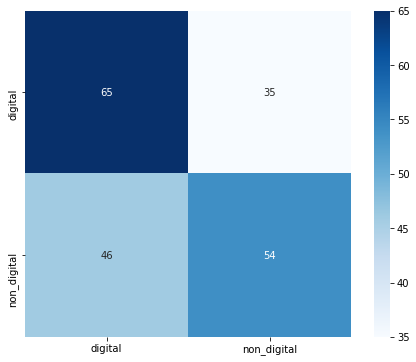

In [11]:
# validation matrix

conf_mat = confusion_matrix(val_generator.classes, model.predict_classes(val_generator))

class_names = list(val_generator.class_indices.keys())

fig, ax = plt.subplots(figsize=(8,6))
final_model_validation_path = pathlib.Path().absolute().parent.parent / 'reports/figures/final_validation_heatmap.png'
ax.set_ylim([0,1])
sns.heatmap(conf_mat, xticklabels=class_names, yticklabels=class_names, ax=ax, square=True, annot=True, cmap='Blues')
plt.savefig(final_model_validation_path)

Next I'll check to see if the final testing data follows the same trend

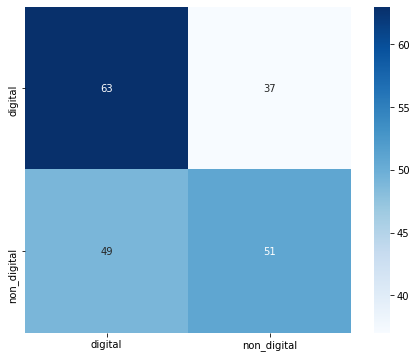

In [12]:
# testing matrix
conf_mat = confusion_matrix(test_generator.classes, model.predict_classes(test_generator))

class_names = list(test_generator.class_indices.keys())

fig, ax = plt.subplots(figsize=(8,6))
final_model_test_path = pathlib.Path().absolute().parent.parent / 'reports/figures/final_test_heatmap.png'
ax.set_ylim([0,1])
sns.heatmap(conf_mat, xticklabels=class_names, yticklabels=class_names, ax=ax, square=True, annot=True, cmap='Blues')
plt.savefig(final_model_test_path)

more evaluation, potential improvements